# Temperature Forecasting with RNN

## 1.0 Setup

- **Problem**: temperature-forecasting with RNN (see 2.1).
- **Source of data**: weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

### 1.1 Download and unzip the data

In [20]:
%%bash

mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip


mkdir: cannot create directory ‘jena_climate’: File exists
--2018-12-02 21:10:16--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.98.107
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.98.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

     0K .......... .......... .......... .......... ..........  0%  973K 14s
    50K .......... .......... .......... .......... ..........  0%  830K 15s
   100K .......... .......... .......... .......... ..........  1% 1.37M 13s
   150K .......... .......... .......... .......... ..........  1% 7.20M 10s
   200K .......... .......... .......... .......... ..........  1% 6.76M 8s
   250K .......... .......... .......... .......... ..........  2% 1.55M 8s
   300K .......... .......... .......... .......... ..........  2% 11.3M 7s
   350K .......... .........

### 1.2 Convert data to numpy arrays

In [22]:
import os 

data_dir = './jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

# for h in header:
#     print(h)
print("Number of data points:", len(lines))

Number of data points: 420551


In [8]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### 1.3 Take a look

We first plot the entire temperature series.

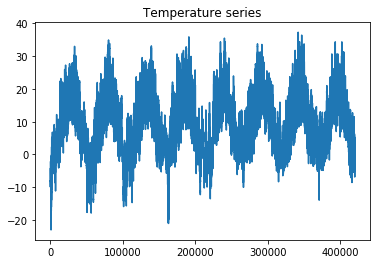

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]
plt.title("Temperature series")
plt.plot(range(len(temp)), temp)

Next, we plot the first 10 days of temperature timeseries. Since data is recorded every 10 minutes, you get 144 data points per day and thus 1440 data points in total. On this plot, we can ses daily periodicity, especially for the last four days.

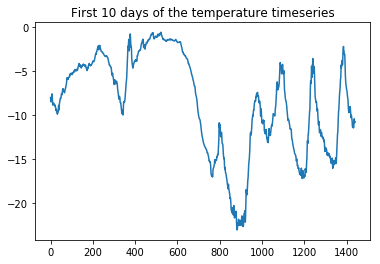

In [14]:
plt.title("First 10 days of the temperature timeseries")
plt.plot(range(1440), temp[:1440])

---
## 2.0 Preprocess

### 2.1 Define the problem

Given data going as far back as `lookback` timesteps (each timestep is 10 minutes) and sampled every `step` timesteps, we want to predict the temperature in `delay` timesteps.

- `lookback = 720`: observations will go back 5 days.
- `steps = 6`: observations will be sampled at one data point per hour.
- `delay = 144`: target will be 24 hours in the future.

### 2.2 Preprocess steps

Normalize each timeseries independently so that they all take small values on a similar scale. 

In [15]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

Next, we write a Python generator that takes current array of float data and yields batches of the data from the recent past, along with a target temperature in the future. This is because the samples in the dataset are highly redundant, it would be wasteful to explicitly allocate every simple. Instead, we'll generate the samples on the fly using the original data.

In [17]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    
    """Yield a tuple (samples, targets), where samples is one batch of input data and targets is
    the corresponding array of target temperatures.
    
    - data: the original array of floating-point data that we normalized above.
    - lookback: how many timesteps back the input data should go.
    - delay: how many timesteps in the future the target should be.
    - min_index, max_index: indices in the data array that delimit which timesteps to draw from.
        This is useful for keeping a segment of data for validation and another for testing.
    - shuffle: whether to shuffle the samples or draw them in chronilogical order.
    - batch_size: the number of samples per batch.
    - step: the period, in timesteps, at which you sample data. We set it to 6 in order to draw
        one data point per hour.  
    """
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

We use the abstract `generator` function to instantiate three generators: one for training, which looks at the first 200000 timesteps; one for validation, which looks at the following 100000; one for test, which looks at the remainder.

In [19]:
lookback = 1440  # 5 days
step = 6         # 1 data point each hour
delay = 144      # next 24 hours

batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)

val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)

test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

# how many steps to draw from val_gen in order to see the entire validate set
val_steps = (300000 - 200001 - lookback) 

# how many steps to draw from test_gen in order to see the entire test set
test_steps = (len(float_data) - 300001 - lookback)

### 2.3 Helper function for plotting

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_accuracy_loss(history):
    history = history.history
    loss, val_loss = history['loss'], history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'm', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

---
## 3.0 Baseline Models

When we are approaching a new problem for which there is no known solution (yet), we should establish baselines before we start using black-box DL models.

### 3.1 A common-sense, non-ML baseline
This non-ML approach will serve as a sanity check and establish a baseline: we predict that the temperature 24 hours from now will equal to the temperature right now and evaluate with MAE.

In [23]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.28969941979609765


Recall the temperature data has been normalized to be centered on 0 and have a standard deviation of 1. We translate it back to degree Celsius:

In [25]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

### 3.2 A basic ML approach

We use a basic regression model:

In [28]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=500, 
    epochs=20, 
    validation_data=val_gen, 
    validation_steps=val_steps
)

Epoch 1/20
496/500 [============================>.] - ETA: 0s - loss: 1.2299

KeyboardInterrupt: 

In [ ]:
plot_accuracy_loss(history)

### 3.3 RNN baseline

The previous approach first flattened the timeseries, which removed the notion of time from the input data. Now we look at the input data as a sequence by using a basic GRU layer (streamlined and cheater but less representational power compared to LSTM). 

In [31]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=500, 
    epochs=20, 
    validation_data=val_gen, 
    validation_steps=val_steps
)

Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 0.3032

KeyboardInterrupt: 

In [ ]:
plot_accuracy_loss(history)

## 4.0 Improvements

### 4.1 Add dropout to fight overfitting

The proper way to use dropout with an RNN is to apply the same dropout mask to the model at every timestep. This allows the network to properly progate its learning error through time. Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. 

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizer import RMSprop

model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

In [ ]:
plot_accuracy_loss(history)

### 4.2 Stacking GRU layers

It's generally a good idea to increase the capacity of your network until overfitting becomes the primary obstacle.

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizer import RMSprop

model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

In [ ]:
plot_accuracy_loss(history)

### 4.3 Bidirectional RNN

A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It is frequently used in NLP.

RNNs are notably order dependent, that is, they process timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. A bidirectional RNN exploits the order sensitivity of RNN -- it consists of using two regular RNNs, such as the `GRU` and `LSTM` layers, each of which processes the input sequence in one direction and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may  be overlooked by a unidirectional RNN.

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Embedding, Bidirectional 
from keras.optimizer import RMSprop

model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

### 5.0 Further improvements

There are many thing we could try at this point to further improve performance on the temperature-forecasting problem:

1. Adjust the number of units in each recurrent layer in the stack setup.
2. Adjust the learning rate of `RMSprop` optimizer.
3. Try `LSTM` instead of `GRU`.
4. Try using a bigger `Dense` layer or even a stack `Dense` layers.

## 6.0 Lessons

1. When approaching a new problem, it's good to first establish common-sense baselines for your metric of choice.
2. Try simple models before expensive ones.
3. RNNs are a great fit for sequential data.
4. To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask.
5. Stacked RNNs provide more representational power but are much more expensive to train.
6. Bidirectional RNNs exploit the order sensitivity of RNN and are widely used in NLP.